# Binary Classification of Malginant Mesothelioma

## Importing Packages

In [12]:
import tensorflow
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D,Flatten,Dense,Dropout,BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, confusion_matrix, roc_curve, classification_report, auc, plot_roc_curve
import time
from sklearn import tree
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from scipy import stats
import statistics
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, LabelEncoder
from sklearn import datasets, metrics
from sklearn.feature_selection import SelectFromModel, RFECV, RFE, SelectKBest, chi2, f_classif, mutual_info_classif, SelectKBest
import shap
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC, LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

## Reading the Data and Data Preprocessing

In [13]:
# Read data
# Transform
mesdata = pd.read_excel(r'C:/Users/tedch/Documents/Thesis/mesdata.xlsx')
mesdata = mesdata.rename(columns={'class of diagnosis': 'diagnosis'})
mesdata.diagnosis.replace({1:0,2:1},inplace=True)
y=mesdata.diagnosis
X=mesdata.drop(['diagnosis', 'diagnosis method', 'pleural protein'],axis=1)
transform=['duration of symptoms', 'platelet count (PLT)', 'alkaline phosphatise (ALP)', 'glucose',
           'pleural lactic dehydrogenise', 'cell count (WBC)', 'blood lactic dehydrogenise (LDH)']
X[transform]=X[transform].apply(np.log)
feature_names = list(X.columns)

X_train,X_test,y_train,y_test= train_test_split(X,y, shuffle=True, test_size=0.2, random_state=42)

sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
oversample = SMOTE(sampling_strategy='minority', random_state=42)
X_train, y_train= oversample.fit_resample(X_train, y_train)

scoring = {'accuracy' : make_scorer(accuracy_score),
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'f1_score' : make_scorer(f1_score)
           #'roc_auc' : make_scorer(roc_auc_score)
           }

## Define a Function to Get the Metrics

In [14]:
def get_scores(scores):
    scoredict={
        'accuracy' : np.mean(scores.get('test_accuracy'))*100,
        'recall' : np.mean(scores.get('test_recall'))*100,
        'precision' : np.mean(scores.get('test_precision'))*100,
        'f1-score' : np.mean(scores.get('test_f1_score'))*100
        #'roc_auc' : np.mean(scores.get('test_roc_auc'))*100
    }
    print(scoredict)

## Artificial Neural Network Model

2/2 [==============================] - 0s 999us/step
--- 1.3241500513894218 seconds ---
{'accuracy': 83.24175824175823, 'recall': 85.93591282666912, 'precision': 70.0455684666211, 'f1-score': 76.41602279232941}


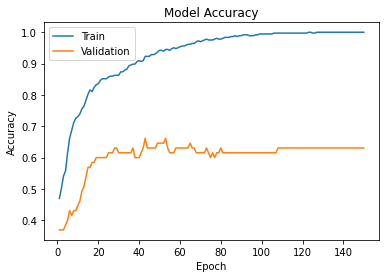

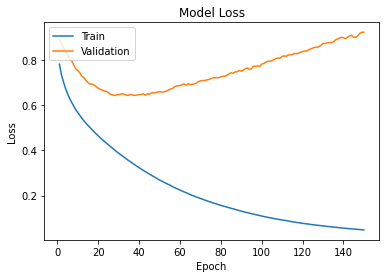

In [15]:
# ANN
tensorflow.random.set_seed(110)

def create_model():
    model = Sequential()
    model.add(Dense(units=32, activation='relu'))
    #model.add(Dense(units=16, activation='relu'))
    #model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

model=KerasClassifier(build_fn=create_model, epochs=150, batch_size=32, verbose=0)
history = model.fit(X_train,y_train,batch_size=32,epochs=150,verbose=0,validation_data=(X_test,y_test))


# Scores
start_time = time.time()
scores = cross_validate(model, X_train, y_train, cv=7, scoring=scoring)
print("--- %s seconds ---" % ((time.time() - start_time)/7))

get_scores(scores)


# Loss graph

epochs=150

epochRange = range(1,epochs+1)
plt.plot(epochRange,history.history['accuracy'])
plt.plot(epochRange,history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

plt.plot(epochRange,history.history['loss'])
plt.plot(epochRange,history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()
